In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.feature_selection import VarianceThreshold

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('../data/TCGA_BRCA_loc_mutf.csv', index_col = 0)

clin_cols = ['age_at_diagnosis', 'ethnicity', 'gender', 'primary_site', 'race', 'submitter_id', 'vital_status']
vital_encode = np.where(data['vital_status'] == 'alive', True, False)
data = data.drop(clin_cols, axis=1)

In [3]:
def lin_svm_optimize(x_train,y_train,C=1):
    lin_svm = svm.SVC(kernel='linear', C=C, class_weight='balanced', random_state=1)
    lin_scores = cross_val_score(lin_svm, x_train, y_train, cv=5)
    lin_avg = sum(lin_scores) / len(lin_scores)
    return lin_avg

In [4]:
def poly3_svm_optimize(x_train,y_train,C=1, coef=0):
    poly3_svm = svm.SVC(kernel='poly', C=C, degree=3 ,coef0=coef, class_weight='balanced')
    poly3_scores = cross_val_score(poly3_svm, x_train, y_train, cv=5)
    poly_avg = sum(poly3_scores) / len(poly3_scores)
    return poly_avg

In [5]:
def poly6_svm_optimize(x_train,y_train,C=1, coef=0):
    poly6_svm = svm.SVC(kernel='poly', C=C, degree=6, coef0=coef, class_weight='balanced')
    poly6_scores = cross_val_score(poly6_svm, x_train, y_train, cv=5)
    poly_avg = sum(poly6_scores) / len(poly6_scores)
    return poly_avg

In [6]:
def gauss_svm_optimize(x_train,y_train,C=1, logGamma=0):
    gauss_svm = svm.SVC(kernel='rbf', C=C, gamma=10**logGamma, class_weight='balanced')
    gauss_scores = cross_val_score(gauss_svm, x_train, y_train, cv=5)
    gauss_avg = sum(gauss_scores) / len(gauss_scores)
    return gauss_avg

In [7]:
def lin_svm_pipe(x_train, y_train, x_test, y_test, cmax, k):
    c_vals = range(1,cmax+1)
    k_vals = range(1,k+1)
    results = np.zeros((k,cmax))
    for k in k_vals:
        x_train_new = SelectKBest(f_classif, k=k).fit_transform(x_train,y_train)
        for c in c_vals:
            results[k-1][c-1] = lin_svm_optimize(x_train_new,y_train,c)
    
    plot_vals(k_vals, c_vals, results)
    k_best,c_best = np.unravel_index(results.argmax(), results.shape)
    k_best += 1
    c_best += 1
    return predict_lin_svm(x_train,y_train, x_test, y_test, k_best,c_best)

In [8]:
def plot_vals(k_vals, c_vals, results):
    X, Y = np.meshgrid(k_vals,c_vals)
    Z = results.reshape(X.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

    ax.set_xlabel('Number of Features')
    ax.set_ylabel('C Values')
    ax.set_zlabel('Accuacy')
    ax.set_title("Linear SVM Accuracy for C value and KBest Features")
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    return None

In [ ]:
def count_prediction(y_predict, y_test):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(0,len(y_predict)):
        if y_predict[i] == y_test[i] and y_predict[i]:
            TP += 1
        elif y_predict[i] == y_test[i] and (not y_predict[i]):
            TN += 1
        elif y_predict[i] != y_test[i] and y_predict[i]:
            FP += 1
        else:
            FN += 1
    return (TP, FP, FN, TN)

In [10]:
def predict_lin_svm(x_train,y_train, x_test, y_test, k,c):
    selector = SelectKBest(f_classif, k=k)
    x_train_new = selector.fit_transform(x_train, y_train)
    lin_svm = svm.SVC(kernel='linear', C=c, class_weight='balanced', random_state=4)
    model = lin_svm.fit(x_train_new,y_train)
    x_test_trim = selector.transform(x_test)
    score = model.score(x_test_trim, y_test)
    print(score)
    y_predict = model.predict(x_test_trim)
    return(count_prediction(y_predict, y_test))

In [11]:
snp_train, snp_test, vital_train, vital_test = train_test_split(data,vital_encode, test_size=0.3, random_state=1)
var_thresh = VarianceThreshold(.999 * (1 - .999))
snp_train_trim = var_thresh.fit_transform(snp_train)
snp_test_trim = var_thresh.transform(snp_test)
selector_50 = SelectKBest(f_classif, k=50)
snp_train_50 = selector_50.fit_transform(snp_train_trim,vital_train)
snp_test_50 = selector_50.transform(snp_test_trim)

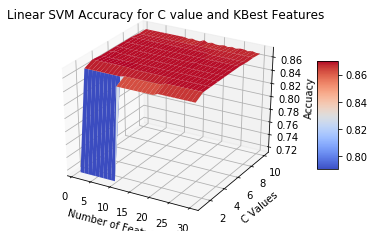

0.8716216216216216


In [12]:
predict_results = lin_svm_pipe(snp_train_50, vital_train, snp_test_50, vital_test, 10, 30)

In [13]:
print(predict_results)

(258, 36, 2, 0)


In [14]:
clin_data = pd.read_csv('../data/clinical_data_processed.csv', index_col =0)
clin_data['vital_status'] = np.where(clin_data['vital_status'] == 'Alive', True, False)
clin_exclude_cols = ['surgical_procedure_first', 'histological_type']
clin_comb = clin_data[clin_data.columns.difference(clin_exclude_cols)]
full_data = data.merge(clin_comb, left_index=True, right_on='bcr_patient_uuid')
full_data.set_index('bcr_patient_uuid',inplace=True,drop=True)
f_vital = full_data['vital_status']
full_data.drop('vital_status',inplace=True, axis=1)

In [15]:
full_train, full_test, fvital_train, fvital_test = train_test_split(full_data,f_vital, test_size=0.3, random_state=1)
var_thresh = VarianceThreshold(.999 * (1 - .999))
full_train_trim = var_thresh.fit_transform(full_train)
full_test_trim = var_thresh.transform(full_test)
selector_50 = SelectKBest(f_classif, k=50)
full_train_50 = selector_50.fit_transform(full_train_trim,fvital_train)
full_test_50 = selector_50.transform(full_test_trim)

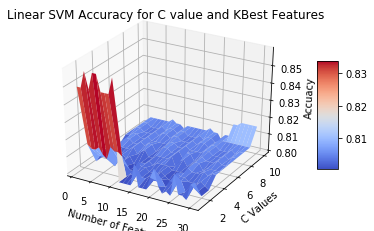

0.8622222222222222
(181, 15, 16, 13)


In [16]:
fpredict_results = lin_svm_pipe(full_train_50, fvital_train, full_test_50, fvital_test, 10, 30)
print(fpredict_results)